In [28]:
import astropy.io.fits as pyfits
import matplotlib.pyplot as plt
import numpy as np
from mpl_toolkits.axes_grid1 import make_axes_locatable

try:
    plt.style.use('seaborn-white')
except:
    plt.style.use('default')

import matplotlib.pylab as pylab
params = {'legend.fontsize': 'x-large',
          'figure.figsize': (5, 5),
         'axes.labelsize': 'x-large',
         'axes.titlesize':'x-large',
         'xtick.labelsize':'10',
         'ytick.labelsize':'10'}
pylab.rcParams.update(params)

PLT_RNG = 3

#Function for color bar
def colorbar(mappable, label=None):
    ax = mappable.axes
    fig = ax.figure
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.05)
    return fig.colorbar(mappable, cax=cax, label=label)


def show_four_row(im1,im2,im3,im4,svmin=0.0,svmax=0.0,title=['','','',''],xlabel='Pixel',ylabel='Pixel',save=False,zoom=1,block=True):

    fig, maps = plt.subplots(1,4,figsize=(12*zoom,3*zoom))
    plt.subplots_adjust(hspace=0.3, wspace=0.3)
    yd,xd = im1.shape
    for i in range(4):
        if i == 0:
            dummy = np.copy(im1)
        if i == 1:
            dummy = np.copy(im2)
        if i == 2:
            dummy = np.copy(im3)
        if i == 3:
            dummy = np.copy(im4)
        try:
            if len(svmin) == 1 or len(svmax) == 1:
                vmin = dummy.mean() - PLT_RNG * dummy.std()
                vmax = dummy.mean() + PLT_RNG * dummy.std()
            else:
                vmin = svmin[i]
                vmax = svmax[i]
        except:
                vmin = np.min(dummy[yd//2-50:yd//2+50,xd//2-50:xd//2+50])
                vmax = np.max(dummy[yd//2-50:yd//2+50,xd//2-50:xd//2+50])
                lim = np.max([np.abs(vmin),vmax])
                vmin = -lim
                vmax = lim

        dummy[dummy<vmin] = vmin
        dummy[dummy>vmax] = vmax
        im = maps[i].imshow(dummy, cmap='gray',vmin = vmin,vmax=vmax)
        maps[i].set_title(title[i])
        if i == 0:
            maps[i].set_ylabel(ylabel)
        maps[i].set_xlabel(xlabel)
        colorbar(im)

    if save != False:
        plt.savefig(save)
        plt.clf()
        return
    plt.show(block = block)

    return




In [70]:
def demodulate(data, filter):

    mod_matrices_david = { 
        "517": {0 : np.array([[0.9655, -0.4865,  0.6307, 0.4986],
                            [0.9476, -0.5615, -0.6319, -0.3653],
                            [1.0471,  0.5569,  0.4372, -0.7102],
                            [1.0398,  0.6294, -0.4595, 0.6237]]),

                1 : np.array([[1.0505, 0.5992 , -0.6032 ,-0.5262],
                            [1.0372, 0.6798 , 0.6194  ,0.3431],
                            [0.9663, -0.4213, -0.4031 , 0.7268],
                            [0.9459, -0.5206, 0.4653  ,-0.5974]])},

        "525.02" : {0 : np.array([[0.9603, -0.5244,  0.6005, 0.4470],
                                [0.9525, -0.5592, -0.6413, -0.3498],
                                [1.0435, 0.5823 ,  0.3865, -0.7071],
                                [1.0437, 0.6645 , -0.4272, 0.6306 ]]),
                                    
                    1 : np.array([[1.0598, 0.6811 ,  -0.6278 , -0.4302],
                                [1.0408,   0.6922 ,  0.5852  ,  0.3614],
                                [0.9610,   -0.4278,  -0.4182 ,  0.6859],
                                [0.9384,   -0.4984,  0.3609  , -0.6310]])},  

        "525.06" : {0 : np.array([[0.9557, -0.5389,  0.5895, 0.4505],
                                [0.9486, -0.5501, -0.6593, -0.3247],
                                [1.0485, 0.5693 , 0.3855 , -0.7246],
                                [1.0473, 0.6737 , -0.4148, 0.6236]]), 

                    1 : np.array([[1.0635, 0.6843 , -0.5910 ,-0.4638],
                                [1.0466, 0.7028 , 0.6070  ,0.3110],
                                [0.9570, -0.3960, -0.3864 ,0.7157],
                                [0.9329, -0.5181, 0.3745  ,-0.6051]])},            
    }

    mod_matrix_0 = mod_matrices_david[filter][0]
    mod_matrix_1 = mod_matrices_david[filter][1]

    print('mod_matrix_0')
    print(mod_matrix_0)
    print('mod_matrix_1')
    print(mod_matrix_1)

    demodM_0 = np.linalg.inv(mod_matrix_0)
    demodM_1 = np.linalg.inv(mod_matrix_1)

    print('demod_matrix_0')
    print(demodM_0)
    print('demod_matrix_1')
    print(demodM_1)

    cam, ls, ps, ys, xs = data.shape

    for i in range(ls):
        data[0, i, :, :, :] = np.reshape(np.matmul(demodM_0, np.reshape(data[0,i, :, :, :], (ps, xs * ys))), (ps, ys, xs))
    for i in range(ls):
        data[1, i, :, :, :] = np.reshape(np.matmul(demodM_1, np.reshape(data[1,i, :, :, :], (ps, xs * ys))), (ps, ys, xs))

    return data

In [71]:
data_file = 'dos_local/test_data/Minimum_success_2_02.fits'
with pyfits.open(data_file) as hdul:
    print(hdul.info())
    data = hdul[0].data
print(data.shape)

Filename: dos_local/test_data/Minimum_success_2_02.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU       9   (2016, 2016, 4, 8, 2)   float64   
None
(2, 8, 4, 2016, 2016)


In [72]:
data_d = demodulate(data, '525.02')

mod_matrix_0
[[ 0.9603 -0.5244  0.6005  0.447 ]
 [ 0.9525 -0.5592 -0.6413 -0.3498]
 [ 1.0435  0.5823  0.3865 -0.7071]
 [ 1.0437  0.6645 -0.4272  0.6306]]
mod_matrix_1
[[ 1.0598 -0.4302  0.6811 -0.6278]
 [ 1.0408  0.3614  0.6922  0.5852]
 [ 0.961   0.6859 -0.4278 -0.4182]
 [ 0.9384 -0.631  -0.4984  0.3609]]
demod_matrix_0
[[ 0.27697634  0.25907527  0.24490435  0.2219917 ]
 [-0.42188601 -0.47280082  0.36908525  0.45064622]
 [ 0.57452029 -0.58424426  0.34694602 -0.34229889]
 [ 0.37535381 -0.32637149 -0.55922689  0.51161238]]
demod_matrix_1
[[ 0.18918847  0.21827677  0.29077526  0.31210632]
 [-0.3700779   0.33233091  0.56439871 -0.52863236]
 [ 0.40214641  0.4297756  -0.4276573  -0.49288847]
 [-0.58360723  0.60701039 -0.35985679  0.3543829 ]]


In [73]:
norma = np.median(data_d[0,0,0,300:-300,300:-300])

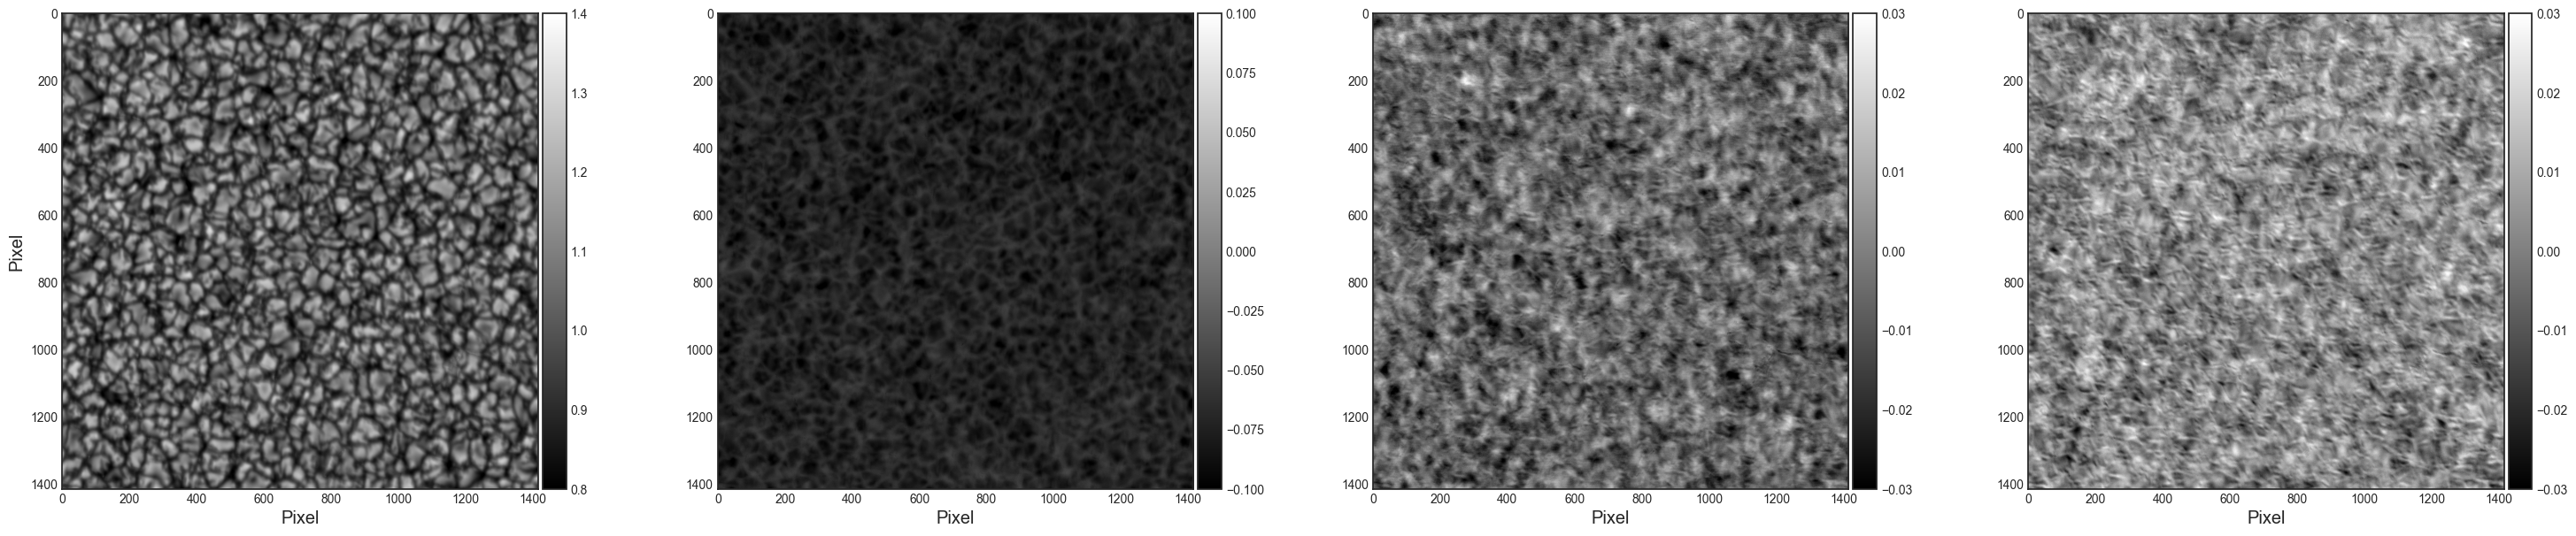

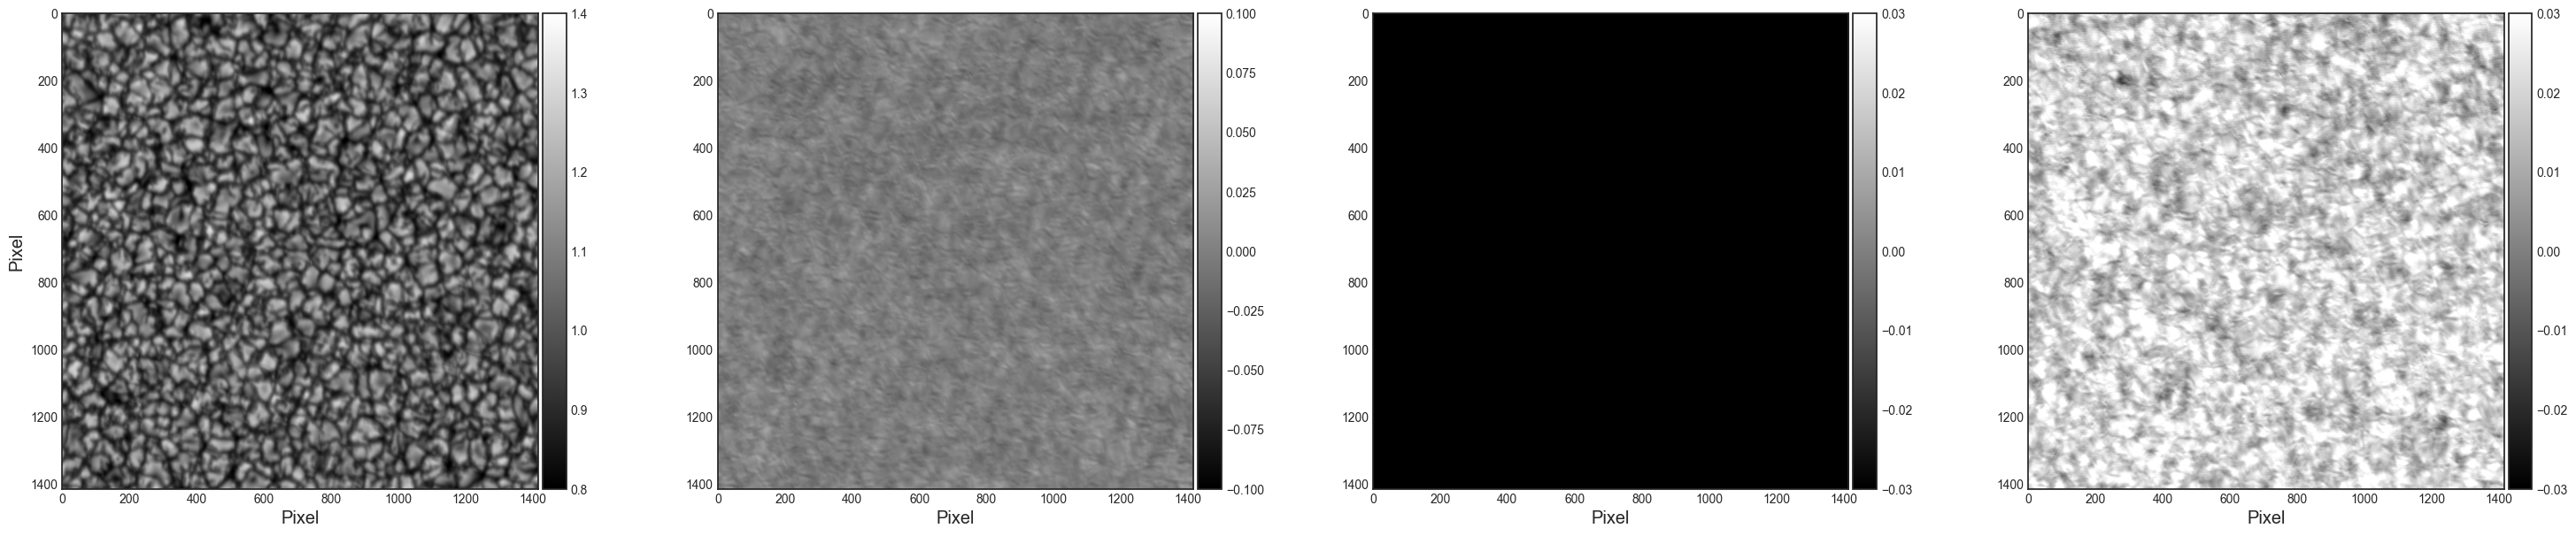

In [74]:
show_four_row(data_d[0,0,0,300:-300,300:-300]/norma,data_d[0,0,1,300:-300,300:-300]/norma,data_d[0,0,2,300:-300,300:-300]/norma,data_d[0,0,3,300:-300,300:-300]/norma,
              svmin=[0.8,-0.1,-0.03,-0.03],svmax=[1.4,0.1,0.03,0.03],zoom=3)

show_four_row(data_d[1,0,0,300:-300,300:-300]/norma,data_d[1,0,1,300:-300,300:-300]/norma,data_d[1,0,2,300:-300,300:-300]/norma,data_d[1,0,3,300:-300,300:-300]/norma,
              svmin=[0.8,-0.1,-0.03,-0.03],svmax=[1.4,0.1,0.03,0.03],zoom=3)
